In [1]:
import os
import sys 
import numpy as np
from keras.models import load_model
import gzip, pickle
from torch_geometric.data import DataLoader
import torch
import smi
import mdm
import gnn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
import pandas as pd

2024-04-29 10:27:19.670265: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 10:27:19.738851: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 10:27:20.256583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 10:27:20.266008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 10:27:21.869759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Loading gnn model , data loader , and creating predictions 

# Defining a path using os.path
path = os.path.join('/home/fostooq/solubility-prediction-paper/data/')

# load data
with gzip.open(path+"train.pkl.gz", "rb") as f:
    train_X = pickle.load(f)
with gzip.open(path+"val.pkl.gz", "rb") as f:
    val_X = pickle.load(f)
with gzip.open(path+"test.pkl.gz", "rb") as f:
    test_X = pickle.load(f)
bs = gnn.config.bs

test_loader = DataLoader(test_X, batch_size=bs, shuffle=False, drop_last=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = gnn.gnn_model.GNN(n_features = gnn.config.n_features).to(device)
model.load_state_dict(torch.load(gnn.config.best_model ))

_, gnn_pred = gnn.gnn_utils.test_fn_plotting(test_loader, model, device)

/home/fostooq/miniconda3/envs/prediction/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/fostooq/miniconda3/envs/prediction/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Loading smi model , smi_x test and creating predictions
smi_x_tes = np.loadtxt("./smi_input/x_test.txt")
smi_model = load_model(smi.config.best_model)
smi_pred = smi_model.predict(smi_x_tes).ravel()

# Loading mdm model, mdm_x_test and creating predictions
mdm_x_test = np.loadtxt("./input/x_test.txt")
mdm_model = load_model(mdm.config.best_model)
mdm_pred = mdm_model.predict(mdm_x_test).reshape(-1,)

# loading y_test, y from all models is identical, using mdm for convenience 
y_test = np.loadtxt("./input/y_test.txt")

2024-04-29 10:29:07.050608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


55/55 [==============================] - 0s 3ms/step


In [4]:
w_gnn = 0.5948275422718199
w_mdm = 0.9463097878036206
w_smi = 0.33177489589161224
sum= w_gnn+w_mdm + w_smi
nw_gnn = w_gnn/sum
nw_mdm = w_mdm/sum
nw_smi = w_smi/sum
CV_pred = (w_gnn * gnn_pred) + (w_mdm * mdm_pred) + (w_smi * smi_pred)
nCV_pred = (nw_gnn * gnn_pred) + (nw_mdm * mdm_pred) + (nw_smi * smi_pred)

In [5]:
weight_gnn = 0.6306445985729451
weight_mdm =0.7775387543020923
weight_smi = 0.4295662789522257

sum_optuna= weight_gnn + weight_mdm + weight_smi
nognn= weight_gnn/ sum_optuna 
nomdm = weight_mdm / sum_optuna
nosmi = weight_smi / sum_optuna
optuna_pred = (nognn * gnn_pred) + (nomdm * mdm_pred) + (nosmi * smi_pred)

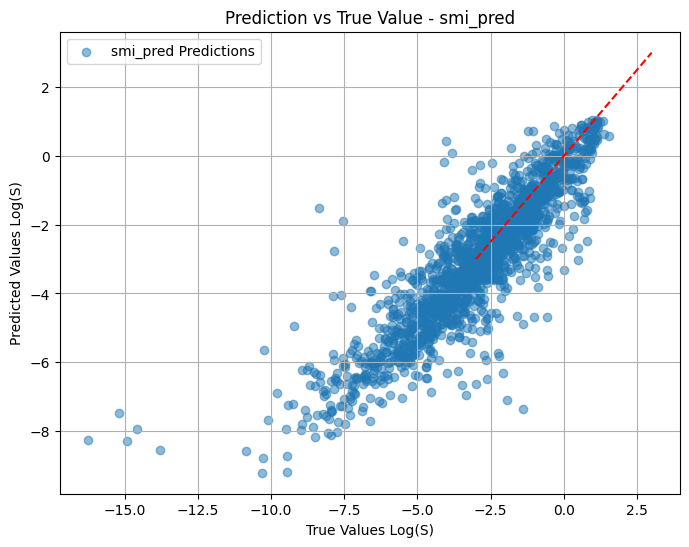

Metrics for smi_pred:
R2: 0.7726
Spearman: 0.8837
RMSE: 1.0741
MAE: 0.7255




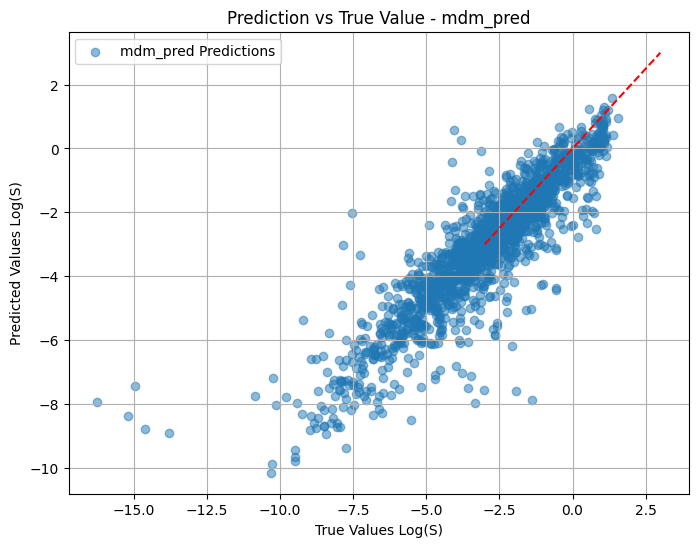

Metrics for mdm_pred:
R2: 0.7973
Spearman: 0.8983
RMSE: 1.0140
MAE: 0.6699




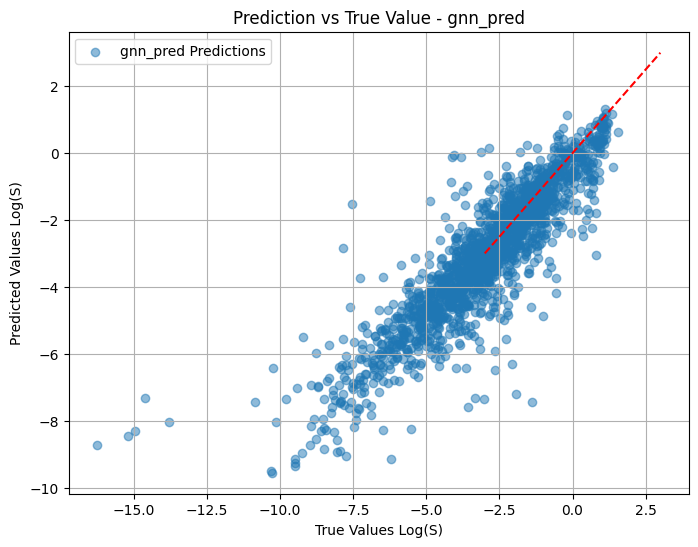

Metrics for gnn_pred:
R2: 0.7941
Spearman: 0.8953
RMSE: 1.0219
MAE: 0.6854




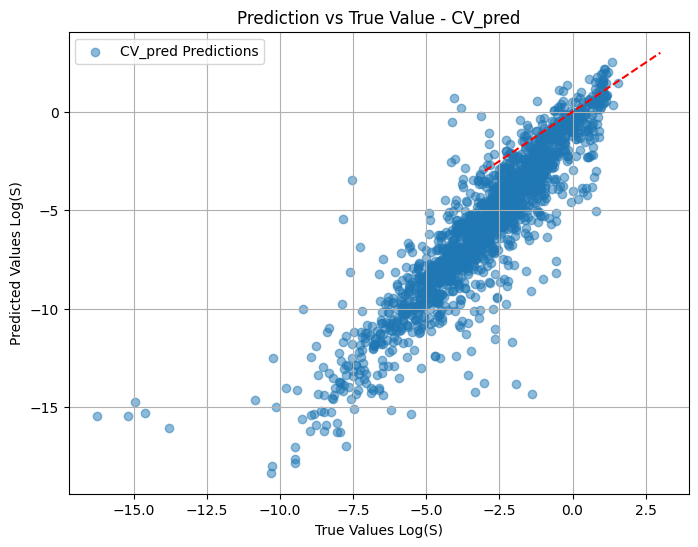

Metrics for CV_pred:
R2: -1.1921
Spearman: 0.9058
RMSE: 3.3348
MAE: 2.7911




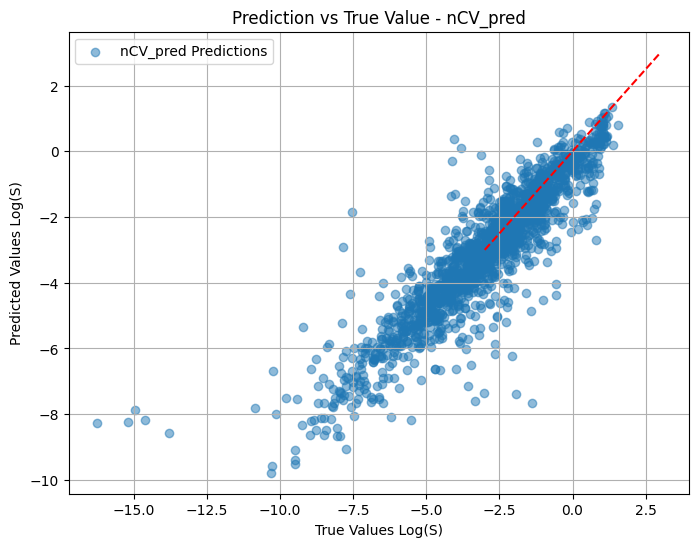

Metrics for nCV_pred:
R2: 0.8116
Spearman: 0.9058
RMSE: 0.9775
MAE: 0.6406




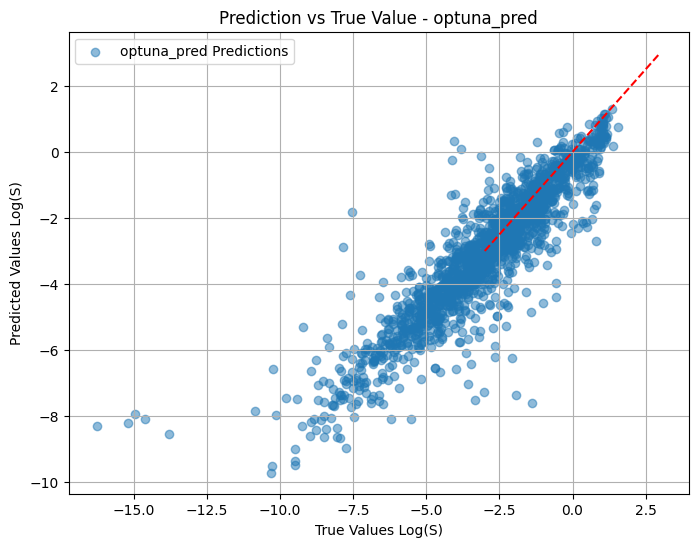

Metrics for optuna_pred:
R2: 0.8117
Spearman: 0.9058
RMSE: 0.9773
MAE: 0.6413




In [6]:

def evaluate_predictions(y_test, **model_predictions):
    metrics = {}
    for model_name, predictions in model_predictions.items():
        r2 = r2_score(y_true=y_test, y_pred=predictions)
        rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
        sp = spearmanr(predictions, y_test)[0]
        mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
        
        metrics[model_name] = {
            'R2': r2,
            'RMSE': rmse,
            'Spearman': sp,
            'MAE': mae
        }
        
        # Plotting
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, predictions, alpha=0.5, label=f'{model_name} Predictions')
        plt.title(f'Prediction vs True Value - {model_name}')
        plt.xlabel('True Values Log(S)')
        plt.ylabel('Predicted Values Log(S)')
        plt.plot([-3, 3], [-3, 3], 'r--')  # Adding a reference line
        plt.grid(True)
        plt.legend()
        plt.show()
        
        print(f"Metrics for {model_name}:")
        print(f"R2: {r2:.4f}")
        print(f"Spearman: {sp:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print("\n")

    return metrics


results = evaluate_predictions(y_test, smi_pred=smi_pred, mdm_pred=mdm_pred, gnn_pred=gnn_pred , CV_pred=CV_pred , nCV_pred=nCV_pred , optuna_pred = optuna_pred)
